In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from datetime import datetime
import matplotlib.dates as mdates
import pylab
plt.style.use('seaborn-whitegrid')

mpl.rcParams['figure.figsize'] = (30, 15)
mpl.rcParams['axes.grid'] = True 

In [2]:
data1 = pd.read_csv('median_confirmation_time.csv')
data2 = pd.read_csv('miners_revenue.csv')
df = pd.merge(data1, data2, on='Timestamp', how='inner')
# 0
condition0_1 = 14
condition0_2 = 32000000
# 1
condition1_1 = 7
condition1_2 = 20000000
df['condition0_1'] = df['median-confirmation-time'].apply(lambda x: 1 if x>=condition0_1 else 0)
df['condition0_2'] = df['miners-revenue'].apply(lambda x: 1 if x>=condition0_2 else 0)
df["condition0"] = df['condition0_1'] * df['condition0_2']
df['condition1_1'] = df['median-confirmation-time'].apply(lambda x: 0 if x<=condition1_1 else 1)
df['condition1_2'] = df['miners-revenue'].apply(lambda x: 0 if x<=condition1_2 else 1)
df["condition1"] = df['condition1_1'] * df['condition1_2']
df['fragility'] = df['condition1']
df = df[['Timestamp', 'median-confirmation-time', 'miners-revenue', 'fragility']]
df.head()

,Timestamp,median-confirmation-time,miners-revenue,fragility
0,02/02/2016 00:00,7.935714,1702667.170,0
1,05/02/2016 00:00,7.402381,1819548.022,0
2,08/02/2016 00:00,7.183333,1864676.027,0
3,11/02/2016 00:00,6.973810,1771362.677,0
4,14/02/2016 00:00,7.180952,1721001.842,0


In [3]:
df['fragility'].value_counts()

0    589
1    141
Name: fragility, dtype: int64

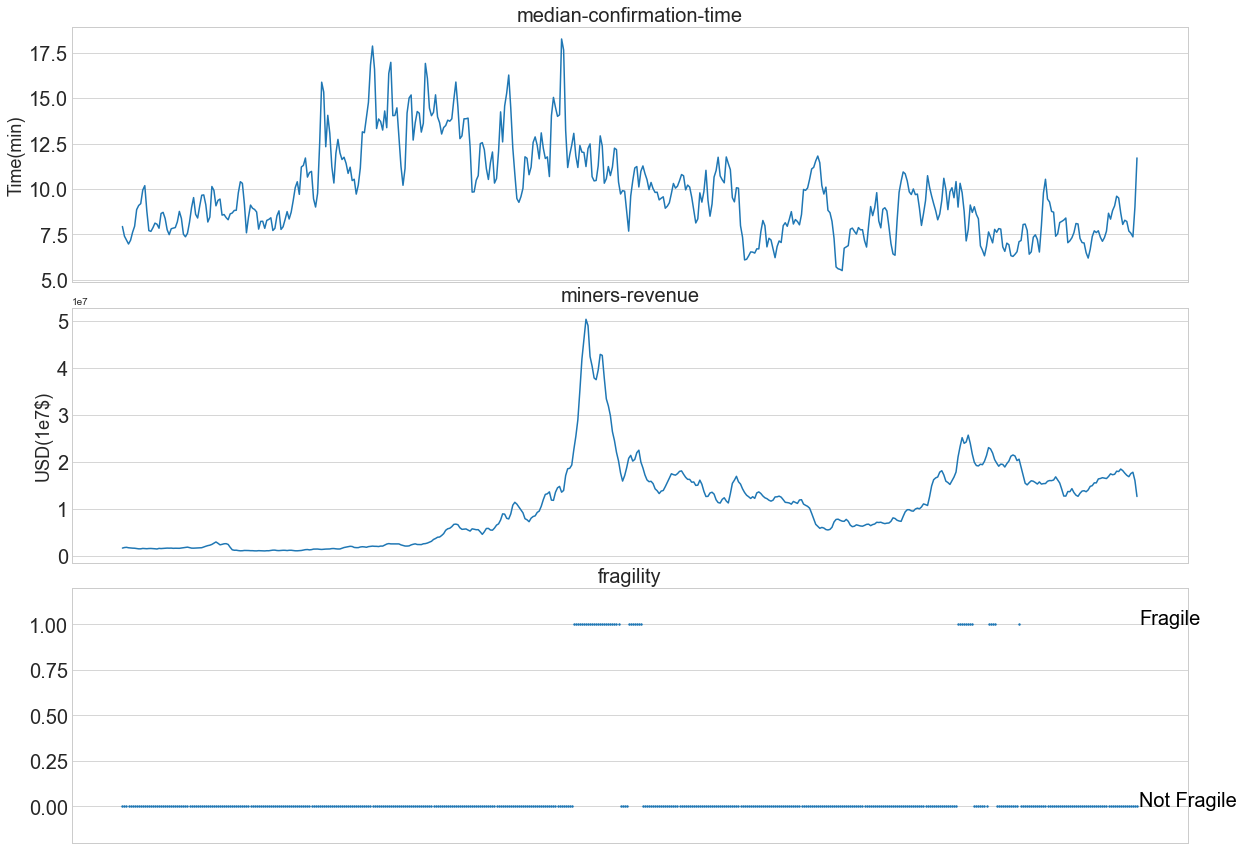

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 15))
plt.subplots_adjust(wspace =0, hspace =0.1)

ax1.plot(df['Timestamp'].values[:500], df['median-confirmation-time'].values[:500])
ax2.plot(df['Timestamp'].values[:500], df['miners-revenue'].values[:500])
ax3.scatter(df['Timestamp'].values[:500], df['fragility'].values[:500], s=2)

half_year_locator = mdates.MonthLocator(interval=5)
ax1.xaxis.set_major_locator(half_year_locator)                                        
ax2.xaxis.set_major_locator(half_year_locator)                                        
ax3.xaxis.set_major_locator(half_year_locator)

ax1.set_title('median-confirmation-time', fontsize=20)
ax2.set_title('miners-revenue', fontsize=20)
ax3.set_title('fragility', fontsize=20)

ax1.set_ylabel('Time(min)', fontsize=18)
ax2.set_ylabel('USD(1e7$)', fontsize=18)

ax1.tick_params(axis='y', which='major', labelsize=20)
ax1.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.tick_params(axis='y', which='major', labelsize=20)
ax2.get_xaxis().set_visible(False)
ax2.tick_params(axis='y', which='major', labelsize=20)

ax3.set_ylim([-0.2, 1.2])

style = dict(size=20, color='black')
ax3.text('1', 0, "Not Fragile", ha='left', **style)
ax3.text('1', 1, "Fragile", ha='left', **style)


plt.show()

C:\Users\BOBBY\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


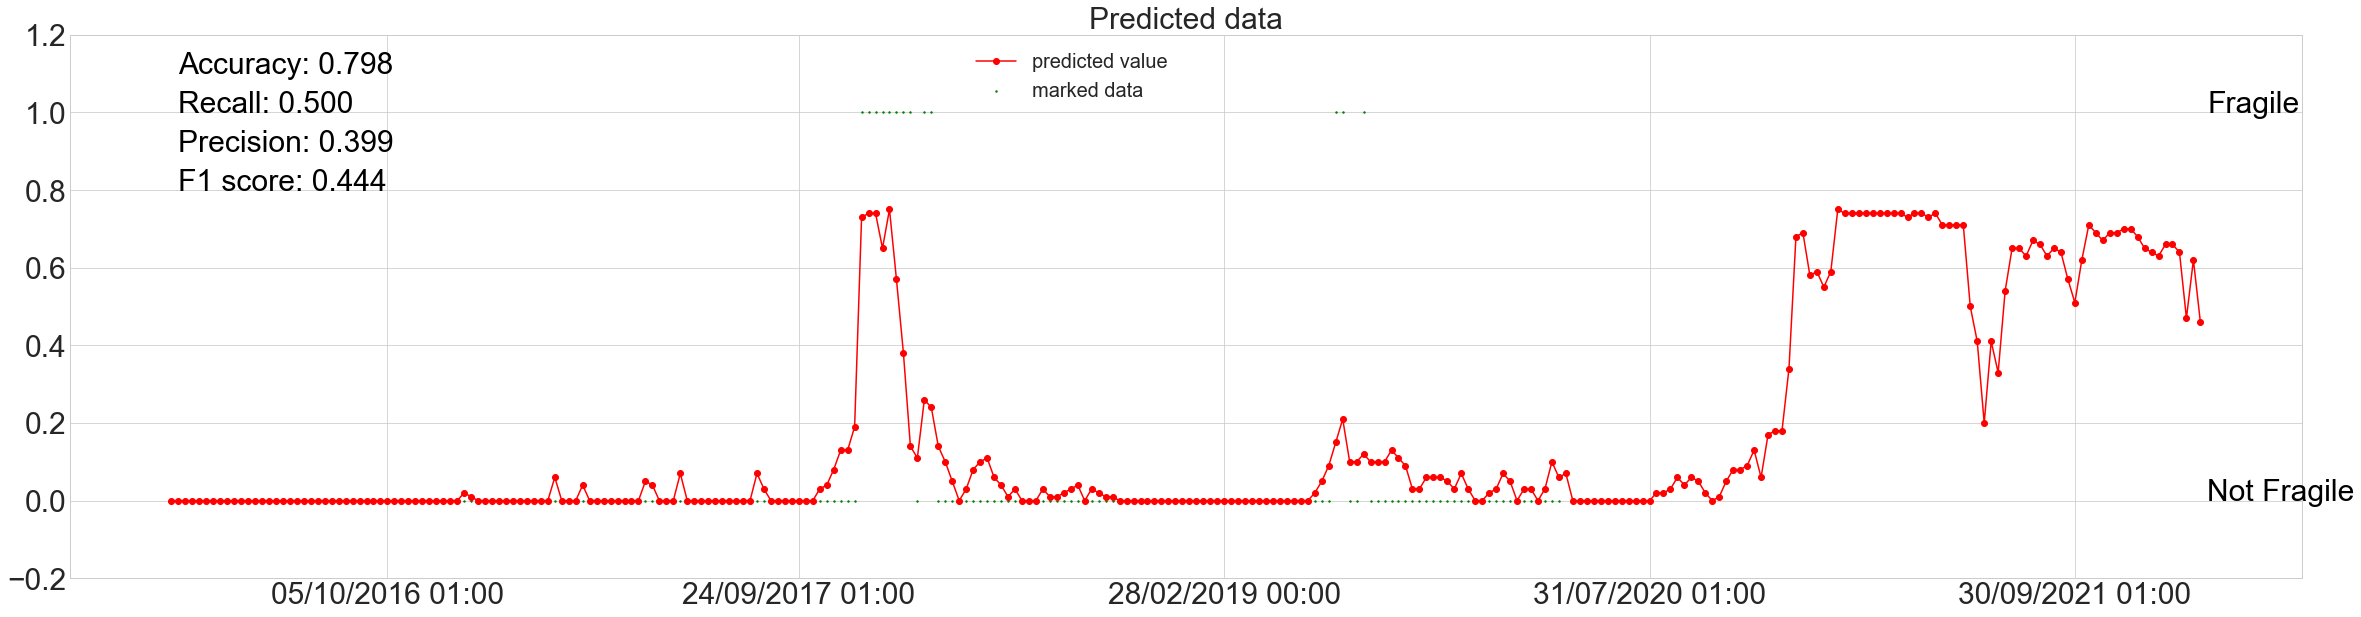

In [5]:
from sklearn import neighbors
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

n_neighbors = 100
for i, weights in enumerate(["uniform"]):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)

df['median-confirmation-time'] = (df['median-confirmation-time'] - df['median-confirmation-time'].min()) / \
                                     (df['median-confirmation-time'].max() - df['median-confirmation-time'].min())
df['miners-revenue'] = (df['miners-revenue'] - df['miners-revenue'].min()) / \
                                 (df['miners-revenue'].max() - df['miners-revenue'].min())

train_df = df.sample(frac=0.6, random_state=0, axis=0)
test_df = df[~df.index.isin(train_df.index)]
knn.fit(train_df[['median-confirmation-time', 'miners-revenue']].values, train_df['fragility'].values)
pred_label = knn.predict(test_df[['median-confirmation-time', 'miners-revenue']].values)



f, ax = plt.subplots(figsize = (40, 10))

ax.scatter(test_df['Timestamp'].values[:200], test_df['fragility'].values[:200], s=2, c='g', marker='o', label='marked data')
ax.plot(test_df['Timestamp'].values, pred_label, '-ro', label='predicted value')

style = dict(size=30, color='black')
ax.text('1', 0, "Not Fragile", ha='left', **style)
ax.text('1', 1, "Fragile", ha='left', **style)

half_year_locator = mdates.MonthLocator(interval=2)
ax.xaxis.set_major_locator(half_year_locator)

ax.set_title('Predicted data', fontsize=30)

ax.text(1, 0.8, 'F1 score: %.3f' % f1_score(test_df['fragility'].values, pred_label.astype('int64'), average='macro'), **style)
ax.text(1, 0.9, 'Precision: %.3f' % precision_score(test_df['fragility'].values, pred_label.astype('int64'), average='macro'), **style)
ax.text(1, 1.0, 'Recall: %.3f' % recall_score(test_df['fragility'].values, pred_label.astype('int64'), average='macro'), **style)
ax.text(1, 1.1, 'Accuracy: %.3f' % accuracy_score(test_df['fragility'].values, pred_label.astype('int64')), **style)

ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)
ax.set_ylim([-0.2, 1.2])
ax.legend(loc="upper right", bbox_to_anchor=(0.5, 1.0), ncol=1, fancybox=True, shadow=True, fontsize=20)
plt.show()